<a href="https://colab.research.google.com/github/JarnovdKolk/Test/blob/main/Hands-on2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


In [2]:
pip install xgboost --user

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [4]:

!mkdir -p data

# Download the file using wget
!wget https://raw.githubusercontent.com/k-woodruff/bdt-tutorial/master/data/training_10k.csv -O data/training_10k.csv
data = pd.read_csv("data/training_10k.csv")

--2025-02-16 10:21:23--  https://raw.githubusercontent.com/k-woodruff/bdt-tutorial/master/data/training_10k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2210243 (2.1M) [text/plain]
Saving to: ‘data/training_10k.csv’

data/training_10k.c 100%[===================>]   2.11M  --.-KB/s    in 0.06s   

2025-02-16 10:21:23 (35.1 MB/s) - ‘data/training_10k.csv’ saved [2210243/2210243]



In [ ]:
print("Size of data: {}".format(data.shape))
print("Number of events: {}".format(data.shape[0]))
print("Number of columns: {}".format(data.shape[1]))

print("\nList of features in dataset:")
for col in data.columns:
    print(col)



Size of data: (10000, 33)
Number of events: 10000
Number of columns: 33

List of features in dataset:
EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label


Number of signal events: 3372
Number of background events: 6628
Fraction signal: 0.3372


<Figure size 640x480 with 0 Axes>

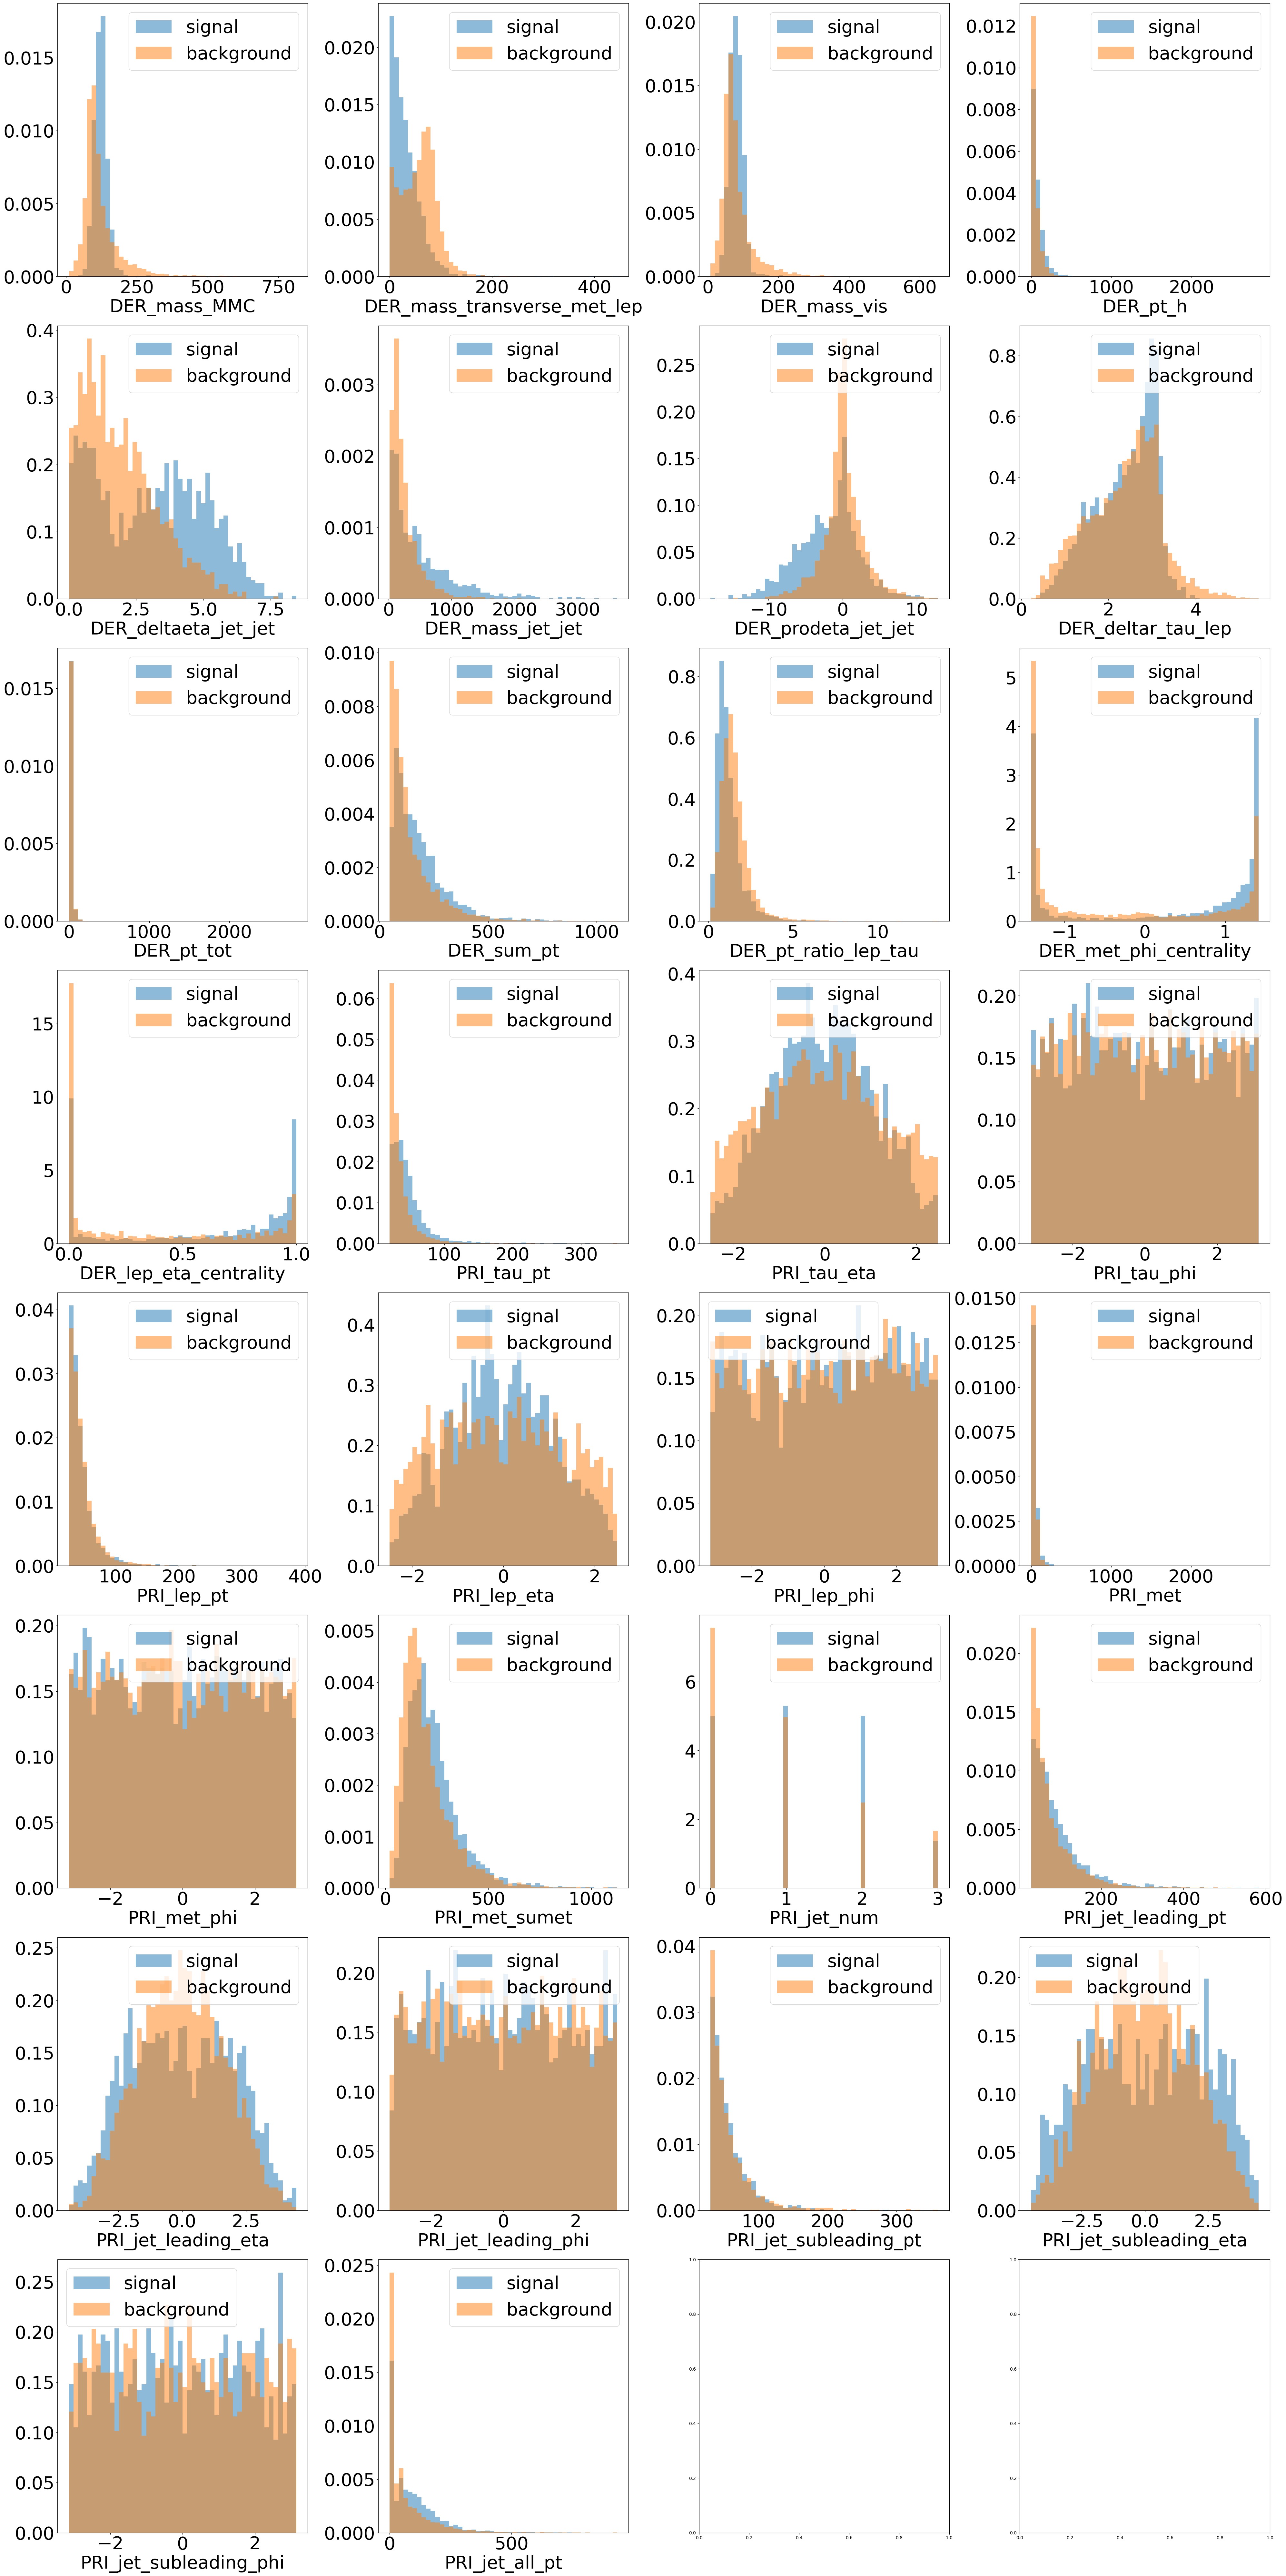

In [ ]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print(f"Number of signal events: {len(data[data.Label == 's'])}")
print(f"Number of background events: {len(data[data.Label == 'b'])}")
print(f"Fraction signal: {len(data[data.Label == 's'])/(len(data[data.Label == 's']) + len(data[data.Label == 'b']))}")

plt.figure()


fig, axs = plt.subplots(8, 4, figsize=(40, 80))

for ix, ax in enumerate(axs.reshape(-1)):
    col = data.columns[ix + 1]
    if col == "Weight" or col == "Label":
        continue
    signal = data[col][data.Label == "s"].to_numpy()
    mask_signal = signal > -999
    background = data[col][data.Label == "b"].to_numpy()
    mask_background = background > -999
    xmin = min(np.min(background[mask_background]), np.min(signal[mask_signal]))
    xmax = max(np.max(background[mask_background]), np.max(signal[mask_signal]))

    ax.hist(signal[mask_signal], bins=np.linspace(xmin, xmax, 51), alpha=0.5, label="signal", density=True)
    ax.hist(background[mask_background], bins=np.linspace(xmin, xmax, 51), alpha=0.5, label="background", density=True)

    ax.set_xlabel(col, fontsize=40)
    ax.set_xlabel(col, fontsize=40)
    ax.tick_params(axis="both", which="major", labelsize=40)
    ax.legend(fontsize=40)
plt.tight_layout()
plt.show()

In [5]:
data["Label"] = data.Label.astype("category")
data_train = data[:8000]
data_test = data[8000:]

print(f"Number of training samples: {len(data_train)}")
print(f"Number of testing samples: {len(data_test)}")
print()
print(f"Number of signal events in training set: {len(data_train[data_train.Label == 's'])}")
print(f"Number of background events in training set: {len(data_train[data_train.Label == 'b'])}")
print(
    f"Fraction signal: {len(data_train[data_train.Label == 's'])/(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b']))}"
)

feature_names = list(data.columns[1:-2])  # we skip the first and last two columns because they are the ID, weight, and label

print(len(feature_names))

train = xgb.DMatrix(
    data=data_train[feature_names], label=data_train.Label.cat.codes, missing=-999.0, feature_names=feature_names
)
test = xgb.DMatrix(
    data=data_test[feature_names], label=data_test.Label.cat.codes, missing=-999.0, feature_names=feature_names
)

print(f"Number of training samples: {train.num_row()}")
print(f"Number of testing samples: {test.num_row()}")
print()
print(f"Number of signal events in training set: {len(np.where(train.get_label())[0])}")

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688
Number of background events in training set: 5312
Fraction signal: 0.336
30
Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688


In [6]:
param = {}

param["seed"] = 42  # set seed for reproducibility

# Booster parameters
param["eta"] = 0.1  # learning rate
param["max_depth"] = 10  # maximum depth of a tree
param["subsample"] = 0.8  # fraction of events to train tree on
param["colsample_bytree"] = 0.8  # fraction of features to train tree on

# Learning task parameters
param["objective"] = "binary:logistic"  # objective function
param["eval_metric"] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
param = list(param.items())

num_trees = 100  # number of trees to make

booster = xgb.train(param, train, num_boost_round=num_trees)
print(booster.eval(test))

[0]	eval-error:0.17299999999999999


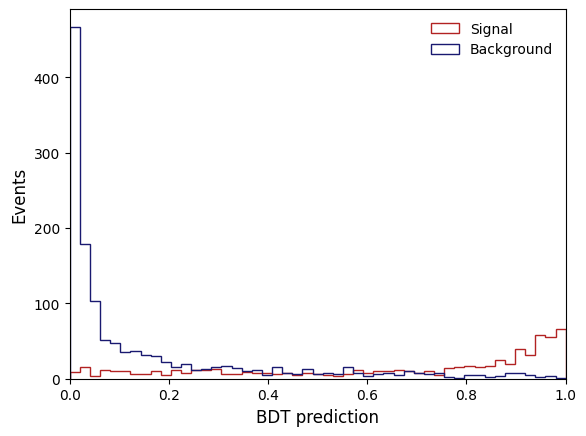

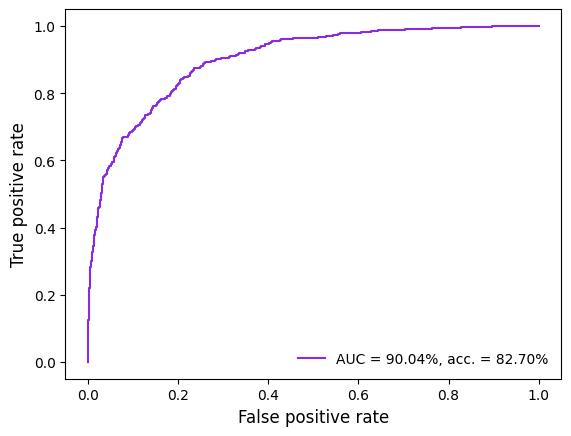

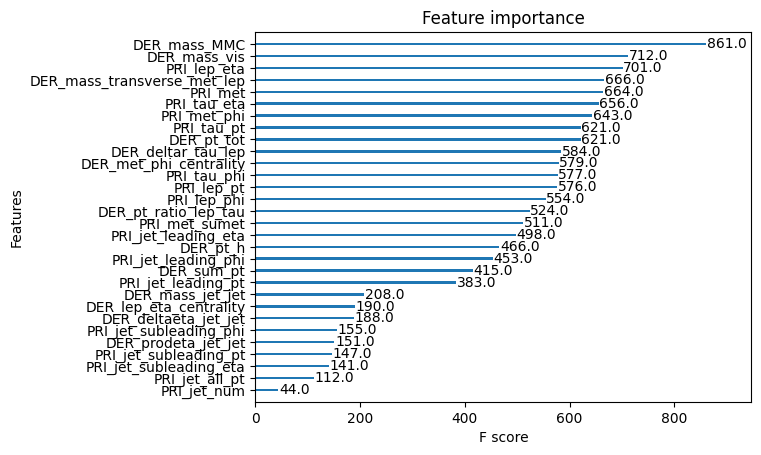

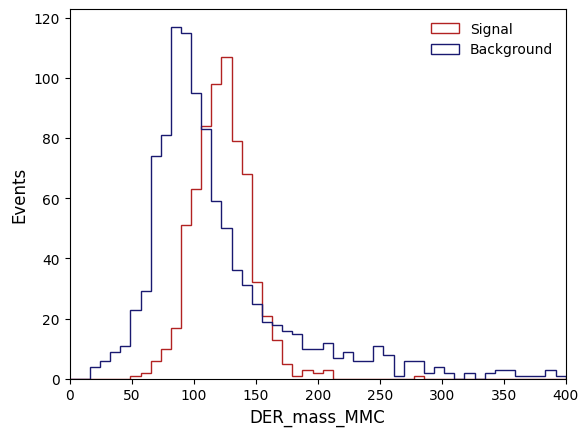

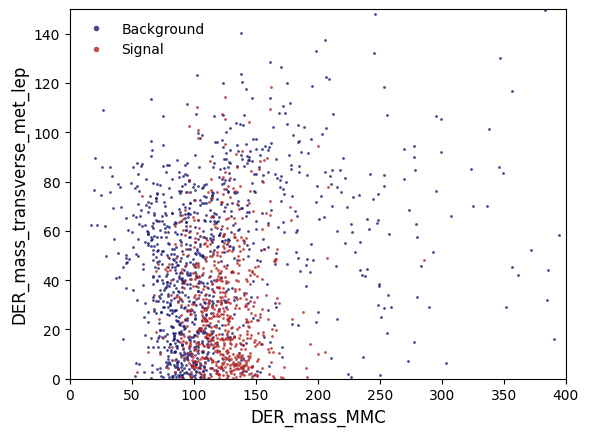

In [9]:
from matplotlib.colors import ListedColormap

predictions = booster.predict(test)
labels = test.get_label().astype(bool)
# plot signal and background predictions, separately
plt.figure()
plt.hist(predictions[labels], bins=np.linspace(0, 1, 50), histtype="step", color="firebrick", label="Signal")
plt.hist(predictions[~labels], bins=np.linspace(0, 1, 50), histtype="step", color="midnightblue", label="Background")
# make the plot readable
plt.xlabel("BDT prediction", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.show()

from sklearn.metrics import roc_curve, auc, accuracy_score

fpr, tpr, _ = roc_curve(labels, predictions)
auc_score = auc(fpr, tpr)
acc_score = accuracy_score(labels, predictions > 0.5)

# plot TPR vs. FPR (ROC curve)
plt.figure()
plt.plot(fpr, tpr, color="blueviolet", label=f"AUC = {auc_score*100:.2f}%, acc. = {acc_score*100:.2f}%")
# make the plot readable
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.legend(frameon=False)
plt.show()

xgb.plot_importance(booster, grid=False)
plt.show()

plt.figure()
plt.hist(
    data_test.DER_mass_MMC[data_test.Label == "s"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="firebrick",
    label="Signal",
)
plt.hist(
    data_test.DER_mass_MMC[data_test.Label == "b"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="midnightblue",
    label="Background",
)

plt.xlim(0, 400)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.show()

plt.figure()

mask_b = np.array(data_test.Label == "b")
mask_s = np.array(data_test.Label == "s")

DER_mass_MMC = np.array(data_test.DER_mass_MMC)
DER_mass_transverse_met_lep = np.array(data_test.DER_mass_transverse_met_lep)

plt.plot(
    DER_mass_MMC[mask_b],
    DER_mass_transverse_met_lep[mask_b],
    "o",
    markersize=2,
    color="midnightblue",
    markeredgewidth=0,
    alpha=0.8,
    label="Background",
)
plt.plot(
    DER_mass_MMC[mask_s],
    DER_mass_transverse_met_lep[mask_s],
    "o",
    markersize=2,
    color="firebrick",
    markeredgewidth=0,
    alpha=0.8,
    label="Signal",
)
plt.xlim(0, 400)
plt.ylim(0, 150)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.show()

<ipython-input-16-f1b99669b787>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(-999.0, np.nan, inplace=True)
<ipython-input-16-f1b99669b787>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


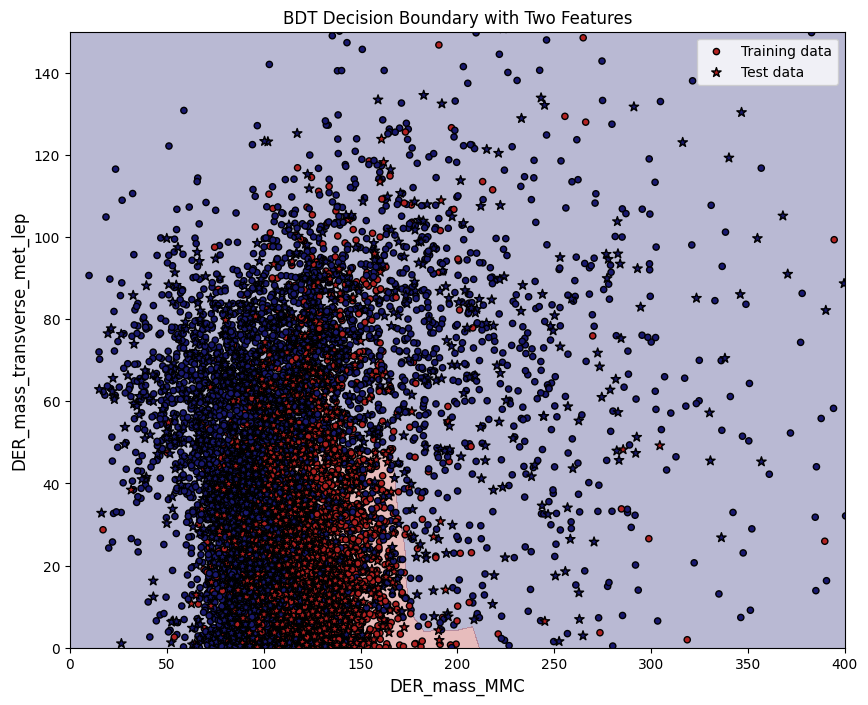

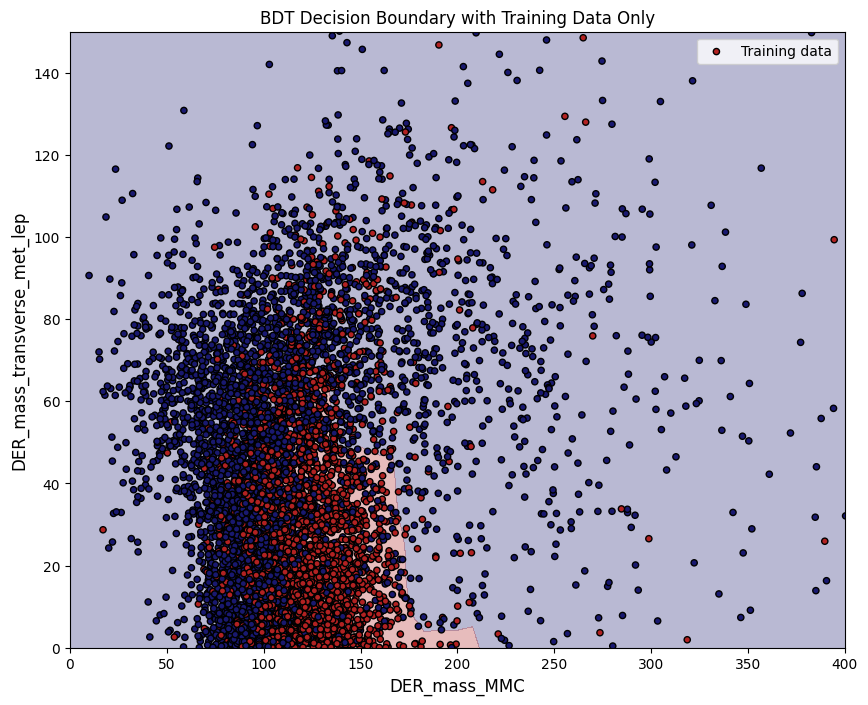

In [16]:
# Load the dataset
data = pd.read_csv("data/training_10k.csv")

# Select the two features and the label
features = ["DER_mass_MMC", "DER_mass_transverse_met_lep"]
X = data[features]
y = data["Label"].map({'s': 1, 'b': 0})  # Map labels to binary values
# Replace -999.0 with NaN
X.replace(-999.0, np.nan, inplace=True)

# Option 1: Drop rows with missing values
X.dropna(inplace=True)
y = y[X.index]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define model parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "max_depth": 4,
    "eta": 0.1,
    "seed": 42
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Create a mesh grid
x_min, x_max = X[features[0]].min() - 10, X[features[0]].max() + 10
y_min, y_max = X[features[1]].min() - 10, X[features[1]].max() + 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Prepare the grid for prediction
grid = np.c_[xx.ravel(), yy.ravel()]
dgrid = xgb.DMatrix(grid, feature_names=features)

# Predict probabilities
zz = bst.predict(dgrid)
zz = zz.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 8))
cmap = ListedColormap(["midnightblue", "firebrick"])
plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], cmap=cmap, alpha=0.3)

# Plot training points
plt.scatter(X_train[features[0]], X_train[features[1]], c=y_train, cmap=cmap, edgecolor='k', s=20, label="Training data")
plt.scatter(X_test[features[0]], X_test[features[1]], c=y_test, cmap=cmap, edgecolor='k', s=50, marker='*', label="Test data")

plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.ylim(0,150)
plt.xlim(0,400)
plt.title("BDT Decision Boundary with Two Features")
plt.legend()
plt.show()

# Plotting only training data with decision boundary
plt.figure(figsize=(10, 8))
cmap = ListedColormap(["midnightblue", "firebrick"])
plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], cmap=cmap, alpha=0.3)

# Plot only training points
plt.scatter(X_train[features[0]], X_train[features[1]], c=y_train, cmap=cmap, edgecolor='k', s=20, label="Training data")

plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.ylim(0, 150)
plt.xlim(0, 400)
plt.title("BDT Decision Boundary with Training Data Only")
plt.legend()
plt.show()